In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.covariance import ledoit_wolf
import cvxpy

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position,
    get_feature_columns,
    get_symbols,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHASEA_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-01-20 17:00:00+00:00 ETH      3246.672906   3249.217225   3227.919297   
                          LINK       22.566893     22.616351     22.301877   
                          MATIC       2.168748      2.172328      2.152781   
                          SOL       142.682324    142.813993    140.193583   
                          XRP         0.758198      0.759136      0.755610   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:30:00+00:00   
                          BTC     10466.256172 2019-07-20 01:30:00+00:00   
                          ETH       221.450416 2019-07-20 01:30:00+00:00   
                          XRP         0.319678 2019-07-20 01:30:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:30:00+00:00   
...                                        ...                       ...   
2022-01-20 17:00:00+00:00 ETH      3233.925579 2022-01-20 18:30:00+00:00   
                          LINK       22.336876 2022-01-20 18:30:00+00:00   
                          MATIC       2.156970 2022-01-20 18:30:00+00:00   
                          SOL       140.246734 2022-01-20 18:30:00+00:00   
                          XRP         0.755840 2022-01-20 18:30:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.037970  
                          BTC     0.028539  
                          ETH     0.028769  
                          XRP     0.036537  
2019-07-20 01:00:00+00:00 BNB     0.005139  
...                                    ...  
2022-01-20 17:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[191843 rows x 6 columns]

In [2]:
class ExampleModelPortfolio:
    def __init__(self):
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script 
    
    def fit(self, df):
        self.symbols = get_symbols(df) # for predict script 
    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values='cl'
        )
        df_x = (df_x / df_x.shift(1) - 1).fillna(0)
        
        mu_len = 24 * 30
        cov_len = 24 * 30
        
        df_weight = df_x.copy() * 0
        for i in range(df_x.shape[0]):
            if df_x.index[i].hour % 2 != 1:
                continue
            df_cov = df_x.iloc[max(0, i - cov_len + 1):i + 1]
            S, _ = ledoit_wolf(df_cov)  
            
            mu = df_x.iloc[max(0, i - mu_len + 1):i + 1].mean(axis=0)

            weight = optimize_mv(
                mu=mu, 
                S=S, 
                target_std=0.04 / (24 ** 0.5), 
                max_total_pos=1.0
            )
            df_weight.iloc[i, :] = weight
        
        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
#         normalize_position(df)
        return df['position']
    
    
def optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    x = cvxpy.Variable(mu.shape[0])
    S = np.array(S)
    mu = np.array(mu)

    objective = cvxpy.Minimize(-mu @ x)
    constraints = [
        cvxpy.quad_form(x, S) <= target_std ** 2,
    ]
    
    if max_total_pos is not None:
        constraints += [
            cvxpy.sum(cvxpy.abs(x)) <= max_total_pos,
        ]

    prob = cvxpy.Problem(objective, constraints)

    try:
        result = prob.solve()
        weight = x.value
        if weight is None:
            print('weight is None')
            weight = np.zeros(mu.size)
    except Exception as e:
        print(e)
        weight = np.zeros(mu.size)

    return weight

return without cost statistics
mean 0.002085694240285051
std 0.03023603441245737
sharpe 0.06898041627528168
max drawdown 0.5847622099166255
return with cost statistics
mean 0.0018751967076040222
std 0.030203864057383917
sharpe 0.06208466254653249
max drawdown 0.5844089069690195


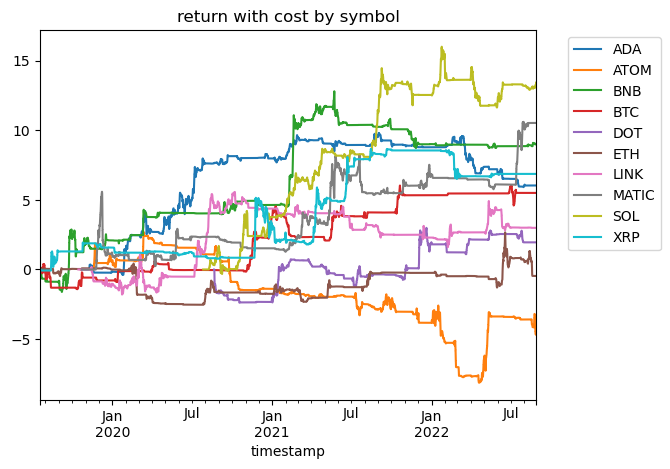

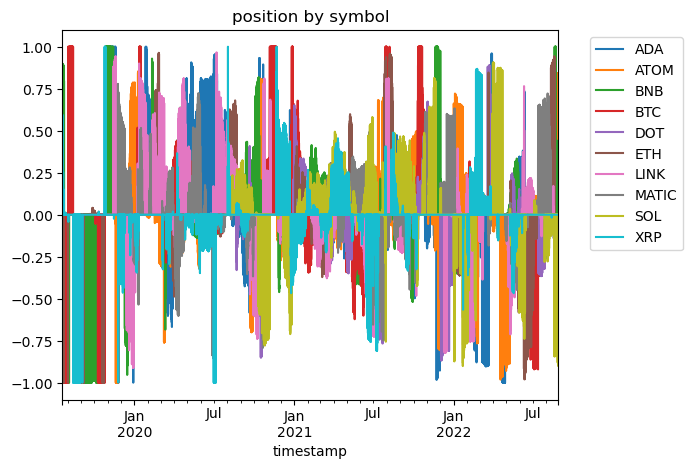

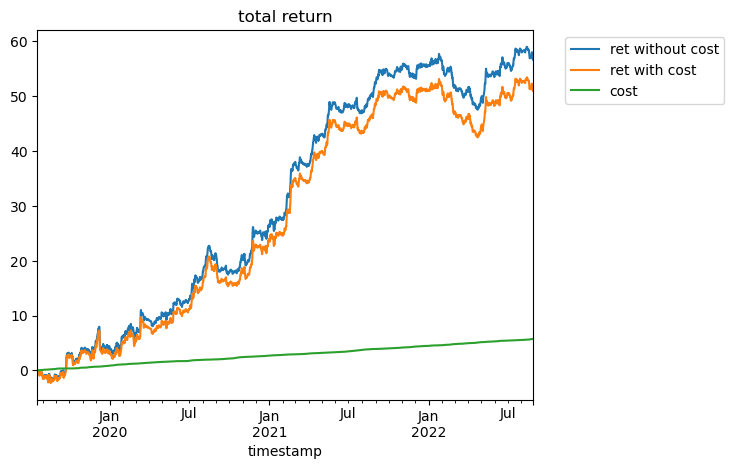

In [3]:
df = pd.read_pickle('/tmp/df.pkl')

model = ExampleModelPortfolio()

df['pos'] = model.predict(df)
visualize_result(df.dropna())

# save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model_portfolio.xz', 'wb') as f:
    f.write(data)

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model_portfolio.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)

timestamp                  symbol
2022-06-30 12:00:00+00:00  ADA       0.0
                           ATOM      0.0
                           BNB       0.0
                           BTC       0.0
                           DOT       0.0
                                    ... 
2022-08-29 12:00:00+00:00  ETH       0.0
                           LINK      0.0
                           MATIC     0.0
                           SOL       0.0
                           XRP       0.0
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
